In [1]:
# import packages
import os, sys, glob
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sys.path.append('../')

In [2]:
# CHANGE FILE AND PARSE ON TAB
# load data such that each row is a sample with one column for name and one for sequence
def load_data(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        seqs = []
        for i in range(0, len(lines)):
            seqs.append(lines[i].strip())
    return pd.DataFrame({'sequence': seqs})

seqs = load_data('../data/clustalo-I20240820-222424-0237-19311203-p1m.aln-fasta.oneline.txt.Residue_Columns.txt')
seqs.head()

,sequence
0,LQWWTCAYPR
1,VQWWTCAFPR
2,VQWWTCAFPR
3,VQWWTCAFPR
4,IQWWTCAFPR


In [3]:
# check sequence lengths
np.unique(seqs['sequence'].apply(len))

array([10])

In [4]:
# get list of unique amino acids
amino_acids = list(set(''.join(seqs['sequence'])))
amino_acids.sort()
len(amino_acids)

21

In [5]:
# SCORES / FEATURES are subject to change
# create a dictionary mapping amino acids to specific features
# first, define features we want to include

# 1. hydrophobicity (ordinal)
hydrophobic = ['A', 'C', 'I', 'L', 'M', 'F', 'V', 'W'] # 0
neutral = ['G', 'H', 'P', 'S', 'T', 'Y'] # 1
hydrophilic = ['R', 'N', 'D', 'Q', 'E', 'K'] # 2
na = ['-']

hydrophobicity = {2: hydrophobic, 
                  1: neutral, 
                  0: hydrophilic,
                  99: na}

# 2. volume (ordinal)
very_small = ['A', 'G', 'S'] #0
small = ['N', 'D', 'C', 'P', 'T'] #1
medium = ['Q', 'E', 'H', 'V'] #2
large = ['R', 'I', 'L', 'K', 'M'] #3
very_large = ['F', 'W', 'Y'] #4
na = ['-']

volume = {0: very_small, 
          1: small, 
          2: medium, 
          3: large, 
          4: very_large,
          0.01: na}

# 3. chemical (arbitrary)
aliphatic = ['A', 'G', 'I', 'L', 'P', 'V']
aromatic = ['F', 'W', 'Y']
sulfur = ['C', 'M']
hydroxyl = ['S', 'T']
basic = ['R', 'H', 'K']
acidic = ['D', 'E']
amide = ['N', 'Q']
na = ['-']

# one-hot encode
chemical = {'aliphatic': aliphatic,
            'aromatic': aromatic,
            'sulfur': sulfur,
            'hydroxyl': hydroxyl,
            'basic': basic,
            'acidic': acidic,
            'amide': amide,
            'na': na}

onehot_chemical = {'aliphatic': [1, 0, 0, 0, 0, 0, 0, 0], 
            'aromatic': [0, 1, 0, 0, 0, 0, 0, 0], 
            'sulfur': [0, 0, 1, 0, 0, 0, 0, 0], 
            'hydroxyl': [0, 0, 0, 1, 0, 0, 0, 0], 
            'basic': [0, 0, 0, 0, 1, 0, 0, 0], 
            'acidic': [0, 0, 0, 0, 0, 1, 0, 0], 
            'amide': [0, 0, 0, 0, 0, 0, 1, 0],
            'na': [0, 0, 0, 0, 0, 0, 0, 1]}

# 4. charge (ordinal)
positive = ['R', 'H', 'K'] #1
negative = ['D', 'E'] #-1
uncharged = ['A', 'N', 'C', 'Q', 'G', 'I', 'L', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] #0
na = ['-']

charge = {1: positive, 
          int(-1): negative, 
          0: uncharged,
          0.01: na}

# 5. hydrogen donor/acceptor (arbitrary)
# MAYBE CHANGE TO BINARY (BOND/NOT)
bond = ['R', 'K', 'W', 'D', 'E', 'N', 'Q', 'H', 'S', 'T', 'Y']
none = ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'V']
na = ['-']

hydrogen = {1: bond,
            0: none,
            0.01: na}

# 6. polarity (ordinal)
polar = ['R', 'N', 'D', 'Q', 'E', 'H', 'K', 'S', 'T', 'Y'] #1
nonpolar = ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'W', 'V'] #0
na = ['-']

polarity = {1: polar, 
            0: nonpolar,
            0.01: na}

# allows us to map amino acids to features, creating a (num_samples, seq_length, num_features) tensor
feature_list = [hydrophobicity, volume, chemical, charge, hydrogen, polarity]

In [6]:
# create feature dictionary that contains the properties of each amino acid
feature_dict = {}

# loop through each amino acid and create a dictionary of features
# loop through amino acids
for aa in amino_acids:
    
    # make list of features for each amino acid
    features = []

    # loop through each feature
    for feature in feature_list:

        # loop through each key in the feature dictionary
        for key, list in feature.items():
            if key in onehot_chemical.keys():
                if aa in list:
                    features.extend(onehot_chemical[key])
                continue
            if aa in list:
                features.append(key)
    feature_dict[aa] = features

# print dictionary for feature conversion
feature_dict

{'-': [99, 0.01, 0, 0, 0, 0, 0, 0, 0, 1, 0.01, 0.01, 0.01],
 'A': [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'C': [2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'D': [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, -1, 1, 1],
 'E': [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, -1, 1, 1],
 'F': [2, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'G': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'H': [1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
 'I': [2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'K': [0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
 'L': [2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'M': [2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'N': [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
 'P': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q': [0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
 'R': [0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1],
 'S': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
 'T': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
 'V': [2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'W': [2, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Y': [1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [7]:
# convert sequences to feature tensors
def seq_to_tensor(seq, feature_dict):
    # initialize tensor
    tensor = []
    
    # loop through each amino acid in the sequence
    for aa in seq:
        # get features for amino acid
        features = feature_dict[aa]
        tensor.append(features)
        
    return np.array(tensor)


In [8]:
# use pool to apply conversion function to all sequences
with mp.Pool(mp.cpu_count()) as pool:
    seq_tensors = pool.map(partial(seq_to_tensor, feature_dict=feature_dict), seqs['sequence'])

# check that all sequences are the same length
np.unique([len(seq) for seq in seq_tensors])

array([10])

In [9]:
# get names
names = seqs['sequence']
print(len(names))

3567


In [10]:
# convert list of tensors to numpy array
seq_tensors = np.array(seq_tensors)
seq_tensors = seq_tensors.reshape(-1, 10*13)
seq_tensors.shape

(3567, 130)

In [26]:
# scale data
seq_tensors_norm = normalize(seq_tensors)

In [32]:
# perform pca
pca = PCA(n_components=2)
pca_result = pca.fit_transform(seq_tensors_norm)

# perform tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
tsne_results = tsne.fit_transform(seq_tensors_norm)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3567 samples in 0.001s...
[t-SNE] Computed neighbors for 3567 samples in 0.719s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3567
[t-SNE] Computed conditional probabilities for sample 2000 / 3567
[t-SNE] Computed conditional probabilities for sample 3000 / 3567
[t-SNE] Computed conditional probabilities for sample 3567 / 3567
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.781338
[t-SNE] KL divergence after 300 iterations: 0.868742


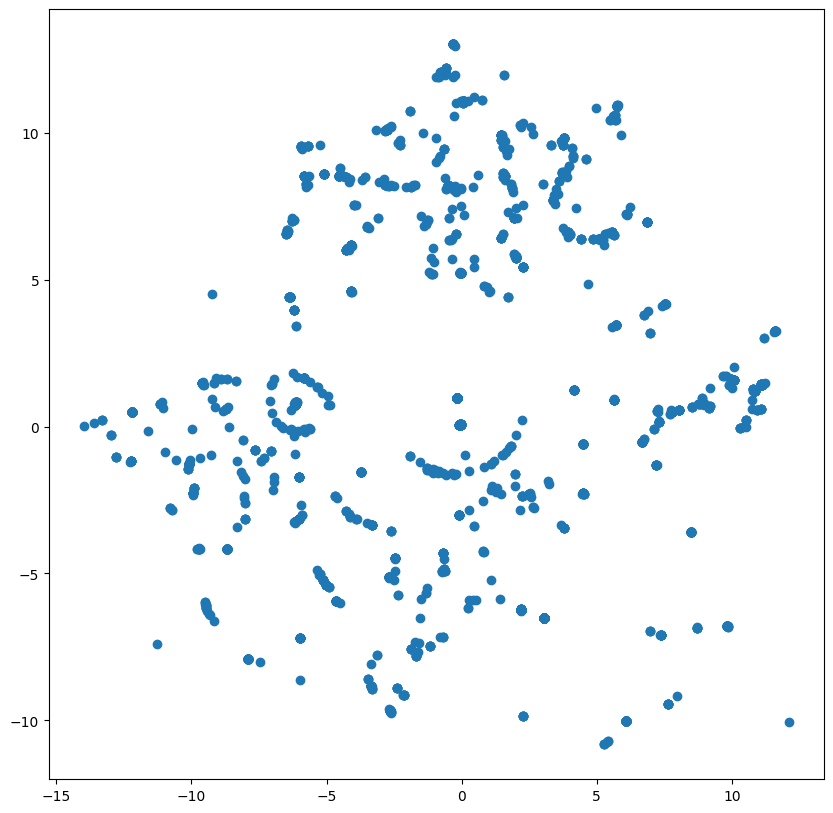

In [28]:
# plot
plt.figure(figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1])
plt.show()

In [29]:
# perform kmeans clustering
K = range(2, 10)
fits = []
score = []

for k in K:
    # fit k clusters on data
    kmeans = KMeans(n_clusters=k, random_state=0).fit(seq_tensors_norm)
    fits.append(kmeans)

    # get silhouette score
    silhouette = silhouette_score(seq_tensors_norm, kmeans.labels_, metric='euclidean')
    score.append(silhouette)
    print(f'k={k}, score={silhouette}')
print(f"Best silhouette score: {min(score)}, for k={score.index(max(score))+2}")

k=2, score=0.5108356566735835
k=3, score=0.7613536162538003
k=4, score=0.7759546424350302
k=5, score=0.8325338863242798
k=6, score=0.7910123010119282
k=7, score=0.7870905824729774
k=8, score=0.8706304508845796
k=9, score=0.8764539428543355
Best silhouette score: 0.5108356566735835, for k=9


<Axes: >

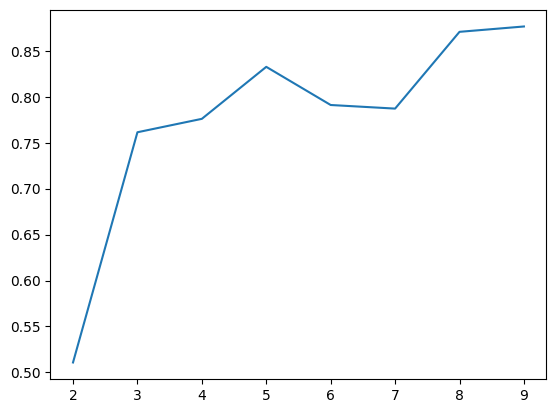

In [30]:
# plot scores vs. k
sns.lineplot(x=K, y=score)

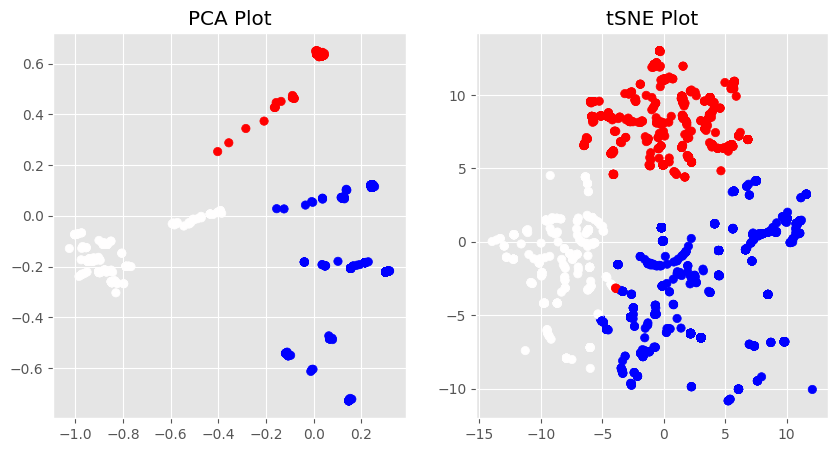

In [40]:
# plot clusters with tsne
classes = fits[1].labels_

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(pca_result[:,0], pca_result[:,1], c=classes, cmap='bwr')
    ax[0].set_title('PCA Plot')
    
    ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=classes, cmap='bwr')
    ax[1].set_title('tSNE Plot')
    plt.show()
